In [93]:
import matplotlib.pyplot as plt
import numpy as np

In [94]:
# Set random seed for reproducibility

# Parameters
num_samples = 1000
num_components = 10
n_dim = 3
n_dim_high = 14

# Generate random means and covariances for each component
means = np.random.randn(num_components, n_dim) * 10
rand_matrix = np.random.rand(n_dim, n_dim)
covariances = [rand_matrix @ rand_matrix.T + 0.1 * np.eye(n_dim) for _ in range(num_components)]

# Normalize weights to sum to 1
weights = np.random.rand(num_components)
weights /= np.sum(weights)

n_samples_comp = np.random.multinomial(num_samples, np.array(weights))

data_list = []
for k, (mean, covariance, sample) in enumerate(zip(means, covariances, n_samples_comp)):
    features = np.dot(np.random.multivariate_normal(mean, covariance, int(sample)), np.random.rand(n_dim, n_dim_high))
    classes = k * np.ones(int(sample))
    data_list.append(np.concatenate([features, classes.reshape(-1, 1)], axis=1))

data = np.vstack(data_list)
data_feat = data[:, :-1]
data_class = data[:, -1]

In [95]:
def generate_random_spd_matrix(n):
    A = np.random.randn(n, n)
    spd_matrix = np.dot(A, A.T)  # Ensure the matrix is symmetric
    spd_matrix += np.eye(n) * 0.1  # Add a small multiple of the identity matrix for positive definiteness
    spectral_radius = np.max(np.abs(np.linalg.eigvals(spd_matrix)))
    if spectral_radius > 2:
        spd_matrix /= (spectral_radius/2)
    return spd_matrix


domains = [data]
for i in range(5):
    affine_matrix = generate_random_spd_matrix(n_dim_high)
    new_data_feat = np.dot(data_feat, affine_matrix)
    new_data = np.concatenate((new_data_feat, data_class.reshape(-1, 1)), axis=1)
    domains.append(new_data)

In [96]:
toy_dataset = np.concatenate((domains[0], np.zeros((domains[0].shape[0], 1))), axis=1)

for i in range(1, len(domains)):
    data_to_concatenate = np.concatenate((domains[i], i * np.ones((domains[0].shape[0], 1))), axis=1)
    toy_dataset = np.concatenate((toy_dataset, data_to_concatenate), axis=0)

In [97]:
np.save('high_dimension_toy_dataset.npy', toy_dataset)

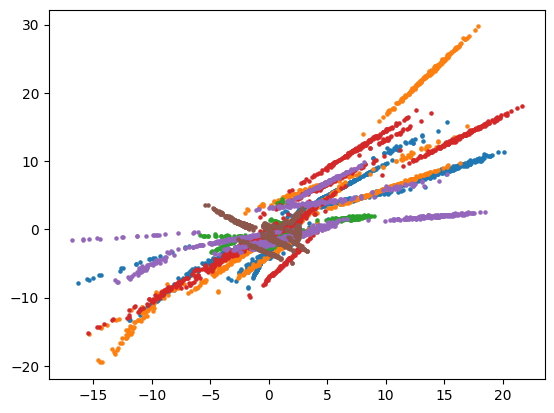

In [98]:
fig, ax = plt.subplots()
for i in range(len(domains)):
    ax.scatter(domains[i][:, 0], domains[i][:, 1], s = 5)

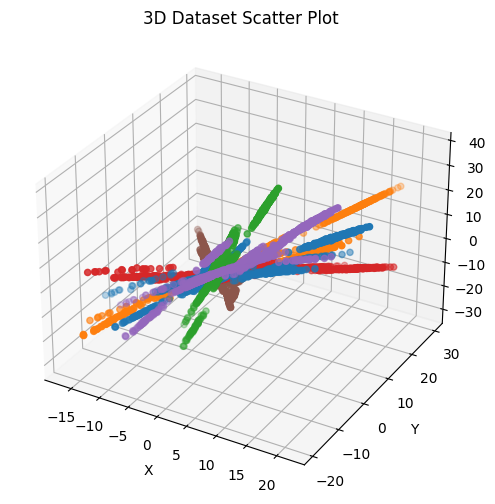

In [99]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the 3D dataset
for i in range(len(domains)):
    ax.scatter(domains[i][:, 0], domains[i][:, 1], domains[i][:, 2])

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set title
ax.set_title('3D Dataset Scatter Plot')

plt.show()


In [100]:
import skdim
import numpy as np

#estimate global intrinsic dimension
danco = skdim.id.DANCo().fit(toy_dataset[:, :-2])
#estimate local intrinsic dimension (dimension in k-nearest-neighborhoods around each point):
'''lpca = skdim.id.lPCA().fit_pw(toy_dataset[:, :-2],
                              n_neighbors = 100,
                              n_jobs = 1)'''

#get estimated intrinsic dimension
print(danco.dimension_)

2.2487699247593085
